# 1. Cài đặt thư viện

In [1]:
%%capture
!pip install torchinfo

In [2]:
# thư viện xử lí dữ liệu
import pandas as pd
import numpy as np

# trực quan dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# os quản lí thư mục
import os

# OrderedDict , cung cấp dữ liệu giống như từ điển (các cặp khoá-giá trị)
from collections import OrderedDict

# tqdm tạo thanh tiến trình (progress bar) giúp theo dõi tiến độ của một vòng lặp
from tqdm.auto import tqdm

# Path
from pathlib import Path

# random
import random

# typing
from typing import Dict, List

# warnings
import warnings
warnings.filterwarnings("ignore")

from copy import deepcopy

import torch.optim as optim

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. Tiền xử lí dữ liệu

## 2.1 Load data

In [3]:
# Tổng số hình ảnh
IMAGE_PATH = Path("/kaggle/input/data-benh-da-lieu/files")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*/*.jpg"))

print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 87


In [4]:
classes = os.listdir(IMAGE_PATH)
classes = sorted(classes)
classes

['acne', 'bags', 'redness']

## 2.2 Thống kê số liệu

In [5]:
# Số lượng hình ảnh mỗi lớp

print("**" * 20)
print(" " * 10, f"Total Classes = {len(classes)}")
print("**" * 20)

for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*/*.jpg"))
    print(f"* {c}: {len(total_images_class)} images")

****************************************
           Total Classes = 3
****************************************
* acne: 30 images
* bags: 27 images
* redness: 30 images


## 2.3 visualize

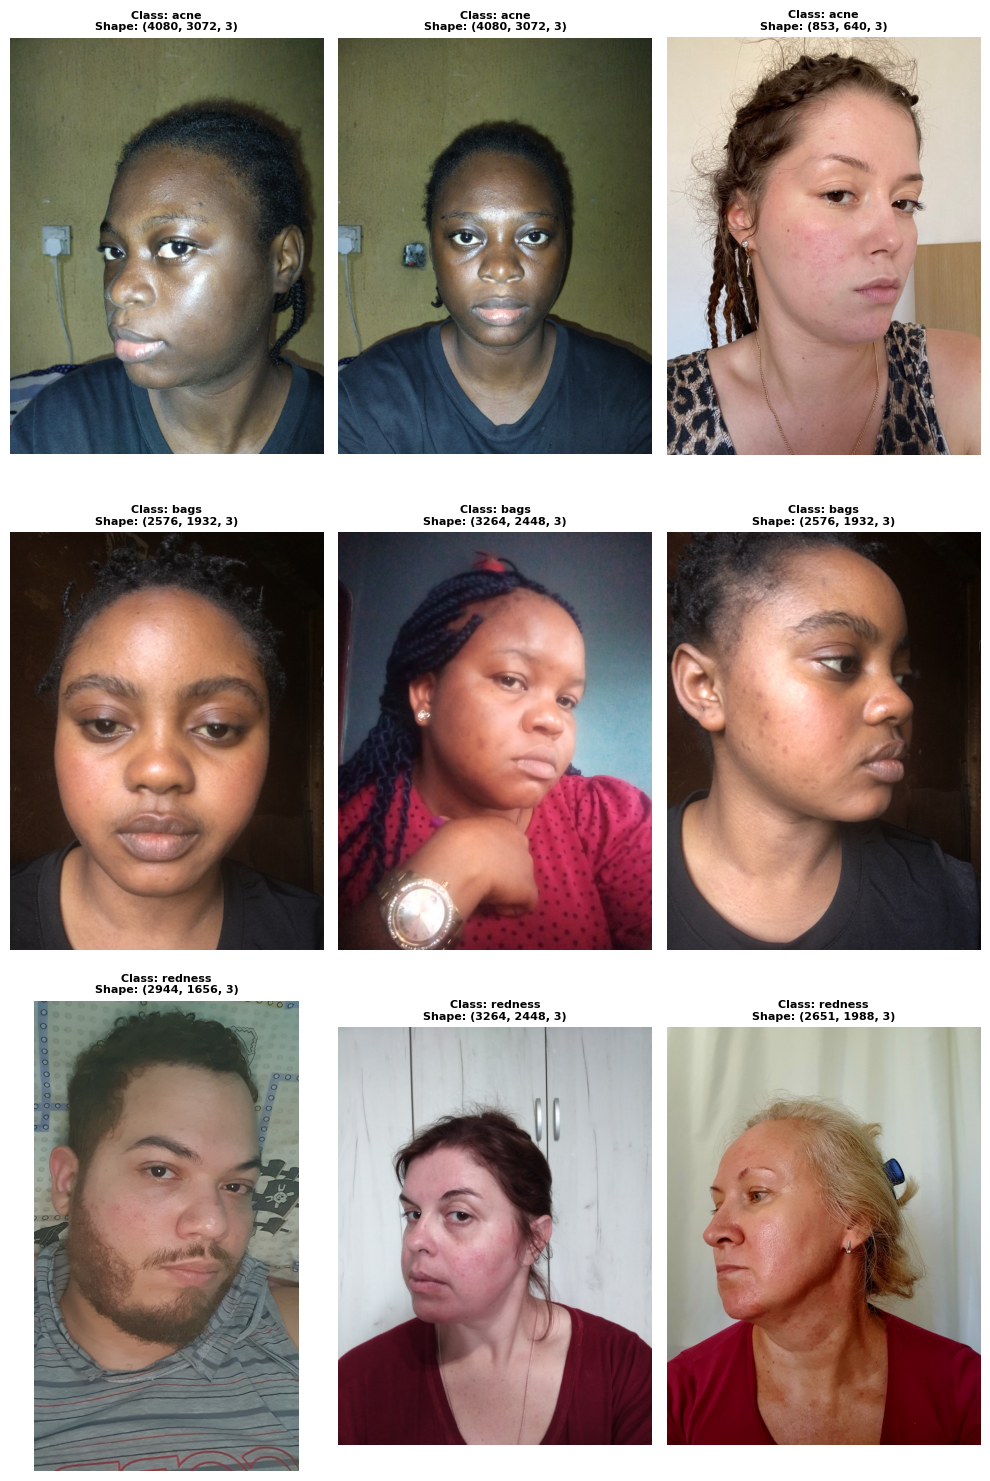

In [6]:
# xem 3 số hình ảnh của mỗi lớp
NUM_IMAGES = 3

fig, ax = plt.subplots(nrows = len(classes), ncols = NUM_IMAGES, figsize = (10,15))
p = 0
for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*/*.jpg"))
    images_selected = random.choices(total_images_class, k = NUM_IMAGES)
    
    for i,img_path in enumerate(images_selected):
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].axis("off")
        ax[p,i].set_title(f"Class: {c}\nShape: {img_rgb.shape}", fontsize = 8, fontweight = "bold", color = "black")
        
    p += 1
    
fig.tight_layout()
fig.show()

## 2.4 Tạo liên kết dữ liệu 

In [7]:
images_path = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i,image_path in enumerate(IMAGE_PATH_LIST):
    images_path[i] = image_path
    labels[i] = image_path.parent.parent.stem
    
df_path_and_label = pd.DataFrame({'path':images_path, 
                                  'label':labels})
df_path_and_label.head()

,path,label
0,/kaggle/input/data-benh-da-lieu/files/acne/7/r...,acne
1,/kaggle/input/data-benh-da-lieu/files/acne/7/f...,acne
2,/kaggle/input/data-benh-da-lieu/files/acne/7/l...,acne
3,/kaggle/input/data-benh-da-lieu/files/acne/2/r...,acne
4,/kaggle/input/data-benh-da-lieu/files/acne/2/f...,acne


## 2.5 Chia dữ liệu train , test

      * train = 70%
      * valid = 15%
      * test = 15%

In [8]:
SEED = 123

df_train, df_rest = tts(df_path_and_label, 
                        test_size = 0.3, 
                        random_state = SEED, 
                        stratify = df_path_and_label["label"])

df_val, df_test = tts(df_rest, 
                      test_size = 0.5, 
                      random_state = SEED, 
                      stratify = df_rest["label"])

In [9]:
# gán số cho lable
label_map = dict(zip(classes, range(0, len(classes))))
label_map

{'acne': 0, 'bags': 1, 'redness': 2}

# 3. Model Vit không áp dụng học liên kết

## 3.1 Áp dụng các trọng số model vit trước đó

In [10]:
weights = ViT_B_16_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

## 3.2 Dataset

In [11]:
class CustomDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transforms, label_map:dict):
        self.df = df
        self.transforms = transforms
        self.label_map = label_map
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        df_new = self.df.copy()
        df_new = df_new.reset_index(drop = True)
        df_new["label"] = df_new["label"].map(self.label_map)
        image_path = df_new.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)
        label = df_new.iloc[idx, 1]
        
        return image,label

In [12]:
train_dataset = CustomDataset(df_train, auto_transforms, label_map)
valid_dataset = CustomDataset(df_val, auto_transforms, label_map)

## 3.3 DataLoader

In [13]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)
valid_dataloader = DataLoader(dataset = valid_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

In [14]:
# Let's visualize the dimensions of a batch.
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

### visualize image(3 layer)

Feature batch shape: torch.Size([1, 3, 224, 224])
Labels batch shape: torch.Size([1])


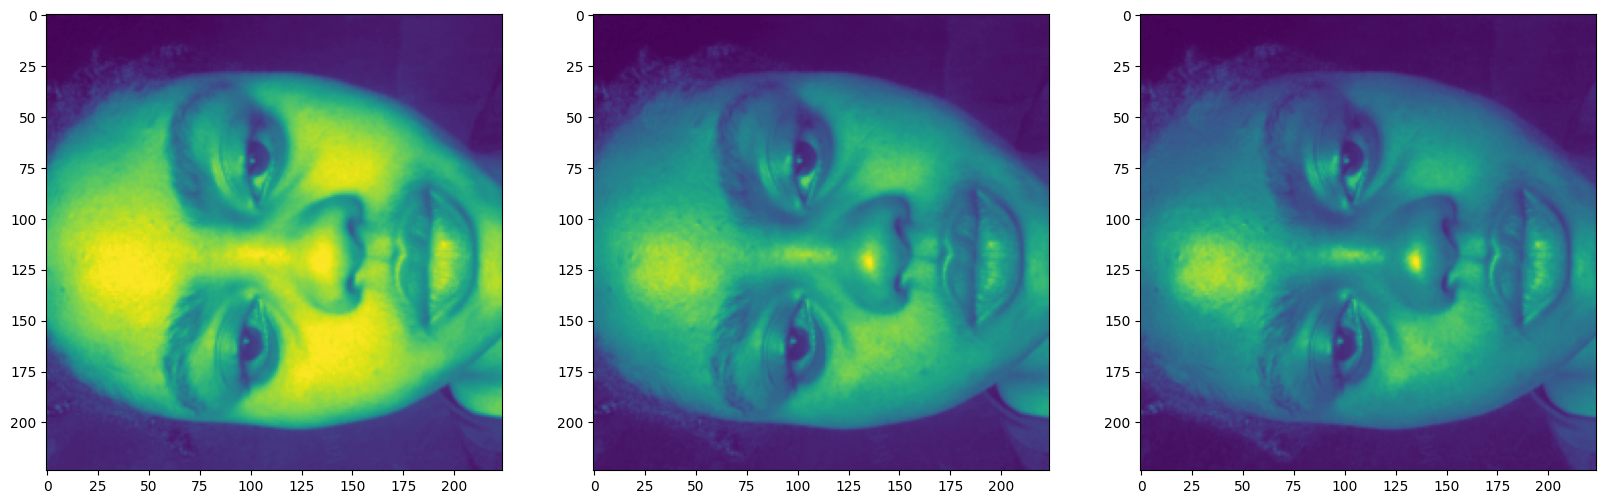

In [15]:
def vis(img):
    fig, axs = plt.subplots(1, 3, figsize=(20, 25))
    axs[0].imshow(img[0])
    axs[1].imshow(img[1])
    axs[2].imshow(img[2])
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].cpu().squeeze()
#label = train_labels[0][0].cpu()
vis(img)
plt.show()
# print(f"Label: {label}")
#plt.imshow(label)

In [16]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
# sử dụng các trọng số đã được đạo tạo trước 
model = vit_b_16(weights = weights)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 316MB/s]


In [18]:
summary(model = model, 
        input_size = [1, 3, 224, 224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 15, 
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 1000]       768             True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] 590,592         True
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         True
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]   [1, 1

### Chúng tôi sẽ cố định các tham số của lớp conv_proj và encoder layers

In [19]:
for param in model.conv_proj.parameters():
    param.requires_grad = False

In [20]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [21]:
# Let's see if the parameters were frozen.
summary(model = model, 
        input_size = [1,3,224,224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 1000]       768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

In [22]:
output_shape = len(classes)

model.heads = nn.Sequential(OrderedDict([('head', nn.Linear(in_features = 768, 
                                                            out_features = output_shape))]))

In [23]:
# One last time let's take a look if the last layer was modified.
summary(model = model, 
        input_size = [1,3,224,224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 3]          768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# 3.5 Các hàm chính 

In [25]:
def train_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, 
               optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0.
    train_accuracy = 0.
    
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred_logit = model(X)
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        train_accuracy += accuracy_score(y.cpu().numpy(), 
                                         y_pred_class.detach().cpu().numpy())
        
    train_loss = train_loss/len(dataloader)
    train_accuracy = train_accuracy/len(dataloader)
    
    return train_loss, train_accuracy

In [26]:
def valid_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module):
    
    model.eval()
    
    valid_loss = 0.
    valid_accuracy = 0.
    
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            y_pred_logit = model(X)
            loss = loss_fn(y_pred_logit, y)
            valid_loss += loss.item()
            
            y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
            y_pred_class = torch.argmax(y_pred_prob, dim = 1)
            
            valid_accuracy += accuracy_score(y.cpu().numpy(), y_pred_class.detach().cpu().numpy())
            
    valid_loss = valid_loss/len(dataloader)
    valid_accuracy = valid_accuracy/len(dataloader)
    
    return valid_loss, valid_accuracy

In [27]:
def save_checkpoint(filename, model, loss, epoch, optimizer, metric):
    state = {"filename":filename, 
             "model":model.state_dict(), 
             "loss":loss, 
             "epoch":epoch, 
             "optimizer":optimizer.state_dict(), 
             "metric":metric}
    
    torch.save(state, filename)

In [28]:
def train(model:torch.nn.Module, 
          train_dataloader:torch.utils.data.DataLoader, 
          valid_dataloader:torch.utils.data.DataLoader, 
          loss_fn:torch.nn.Module, 
          optimizer:torch.optim.Optimizer, 
          epochs:int = 10):
    
    results = {"train_loss":[], 
               "train_accuracy":[], 
               "valid_loss":[], 
               "valid_accuracy":[]}
    
    best_valid_loss = float("inf")
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model, 
                                                dataloader = train_dataloader, 
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
        
        valid_loss, valid_accuracy = valid_step(model = model, 
                                                dataloader = valid_dataloader, 
                                                loss_fn = loss_fn)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            file_name = "best_model.pth"
            save_checkpoint(file_name, model, best_valid_loss, epoch, optimizer, valid_accuracy)
            
        print(f"Epoch: {epoch + 1} | ", 
              f"Train Loss: {train_loss:.4f} | ", 
              f"Train Accuracy: {train_accuracy:.4f} | ", 
              f"Valid Loss: {valid_loss:.4f} | ", 
              f"Valid Accuracy: {valid_accuracy:.4f}")
        
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["valid_loss"].append(valid_loss)
        results["valid_accuracy"].append(valid_accuracy)
        
    return results

In [29]:
EPOCHS = 100

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

MODEL_RESULTS = train(model.to(device), 
                      train_dataloader, 
                      valid_dataloader, 
                      loss_fn, 
                      optimizer, 
                      EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 1.9979 |  Train Accuracy: 0.3500 |  Valid Loss: 3.3600 |  Valid Accuracy: 0.3077
Epoch: 2 |  Train Loss: 1.3623 |  Train Accuracy: 0.5667 |  Valid Loss: 2.0988 |  Valid Accuracy: 0.3846
Epoch: 3 |  Train Loss: 1.2796 |  Train Accuracy: 0.6333 |  Valid Loss: 0.8398 |  Valid Accuracy: 0.7692
Epoch: 4 |  Train Loss: 1.0884 |  Train Accuracy: 0.6667 |  Valid Loss: 2.7279 |  Valid Accuracy: 0.4615
Epoch: 5 |  Train Loss: 0.4119 |  Train Accuracy: 0.9167 |  Valid Loss: 0.3946 |  Valid Accuracy: 0.7692
Epoch: 6 |  Train Loss: 0.4268 |  Train Accuracy: 0.8667 |  Valid Loss: 2.0885 |  Valid Accuracy: 0.4615
Epoch: 7 |  Train Loss: 0.8353 |  Train Accuracy: 0.7667 |  Valid Loss: 2.2780 |  Valid Accuracy: 0.6154
Epoch: 8 |  Train Loss: 2.4294 |  Train Accuracy: 0.5667 |  Valid Loss: 2.6441 |  Valid Accuracy: 0.4615
Epoch: 9 |  Train Loss: 1.8447 |  Train Accuracy: 0.6167 |  Valid Loss: 1.8198 |  Valid Accuracy: 0.5385
Epoch: 10 |  Train Loss: 0.6138 |  Train Accuracy: 0.81

## 3.6 Visualize loss vs accuracy

In [30]:
# Function to plot the loss and metric during each training epoch.
def loss_metric_curve_plot(model_results:Dict[str,List[float]]):
    
    train_loss = model_results["train_loss"]
    valid_loss = model_results["valid_loss"]
    
    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    valid_accuracy = [float(value) for value in model_results["valid_accuracy"]]
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    axes = axes.flat
    
    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(valid_loss, color = "blue", label = "Valid")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()
    
    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(valid_accuracy, color = "blue", label = "Valid")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()
    
    fig.tight_layout()
    fig.show()

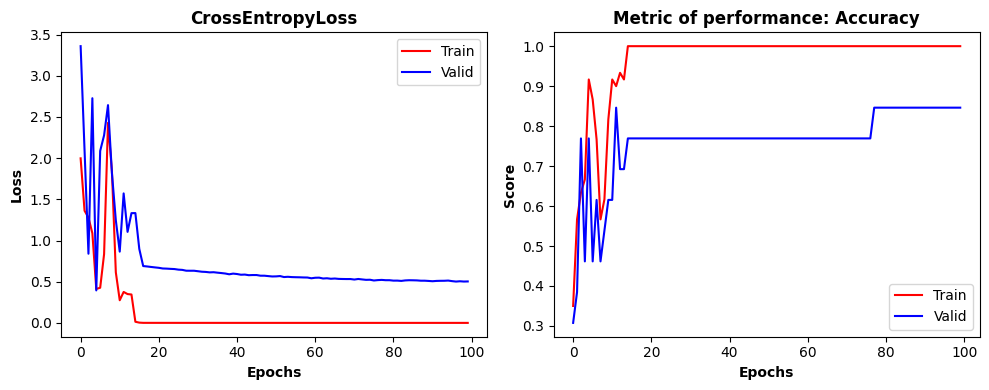

In [31]:
loss_metric_curve_plot(MODEL_RESULTS)

In [32]:
checkpoint_path = "/kaggle/working/best_model.pth"
checkpoint = torch.load(checkpoint_path)

In [33]:
print(f'Best Loss: {checkpoint["loss"]}')
print(f'Epoch: {checkpoint["epoch"] + 1}')
print(f'Best Metric: {checkpoint["metric"]}')

Best Loss: 0.3945670824569578
Epoch: 5
Best Metric: 0.7692307692307693


## 3.7 test

In [34]:
# First of all, we create the Dataset, DataLoader
test_dataset = CustomDataset(df_test, auto_transforms, label_map)
test_dataloader = DataLoader(dataset = test_dataset, shuffle = False, num_workers = NUM_WORKERS)

In [35]:
# We define the model again with its respective modification.
loaded_model = vit_b_16()

loaded_model.heads = nn.Sequential(OrderedDict([('head',nn.Linear(in_features = 768, 
                                                                  out_features = output_shape))]))

loaded_model.load_state_dict(checkpoint["model"])

# We now infer
loaded_model.to(device)

loaded_model.eval()

y_pred_test = []

with torch.inference_mode():
    for X,y in tqdm(test_dataloader):
        X,y = X.to(device), y.to(device)
        y_pred_logit = loaded_model(X)
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        y_pred_test.append(y_pred_class.detach().cpu())

  0%|          | 0/14 [00:00<?, ?it/s]

In [36]:
y_pred_test = torch.cat(y_pred_test).numpy()

In [37]:
print(f'Accuracy = {round(accuracy_score(df_test["label"].map(label_map), y_pred_test), 4)}')

Accuracy = 0.7143


In [38]:
confusion_matrix_test = confusion_matrix(df_test["label"].map(label_map), y_pred_test)

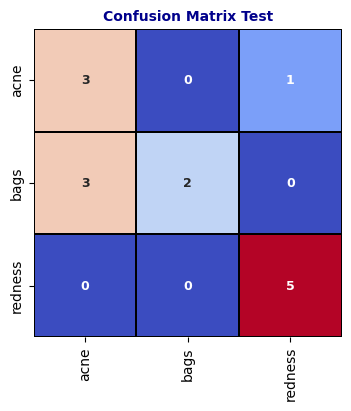

In [39]:
fig,ax = plt.subplots(figsize = (15,4))
sns.heatmap(confusion_matrix_test, 
            cmap = 'coolwarm', 
            annot = True, 
            annot_kws = {"fontsize":9, "fontweight":"bold"}, 
            linewidths = 1.2, 
            linecolor = "black", 
            square = True, 
            xticklabels = classes, 
            yticklabels = classes, 
            cbar = False,
            ax = ax)
ax.set_title("Confusion Matrix Test", fontsize = 10, fontweight = "bold", color = "darkblue")
ax.tick_params('x',rotation = 90)
fig.show()

# 4. Model Vit Áp dụng học liên kết

## 4.1 Chia data thành các node (khách hàng)

In [40]:
def simulate_data(dataset, num_nodes):
    points = np.random.randint(1, 5, size=num_nodes)
    points = points * len(dataset) / points.sum()
    points = points.astype(int)
    points[-1] += len(dataset) - points.sum()
    list_data = torch.utils.data.random_split(dataset, points)
    
    plt.title('data distribution all node')
    plt.bar(np.arange(len(points)), points)
    plt.show()
    
    return list_data

In [41]:
class Arguments():
    def __init__(self):
        self.mu = 0 # Proximal term
        self.q = 0 # Fair Resource Allocation
        
        self.B = 1 # local batch size
        
        self.E = 10 # local epoch
        self.n_iter = 30 # global epoch
        self.lr =  0.000008 # learning rate
        
        self.K = 10 # total node
        
        self.C = 0.1 # frac node
        self.verbose = False # verbose
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        

args = Arguments()

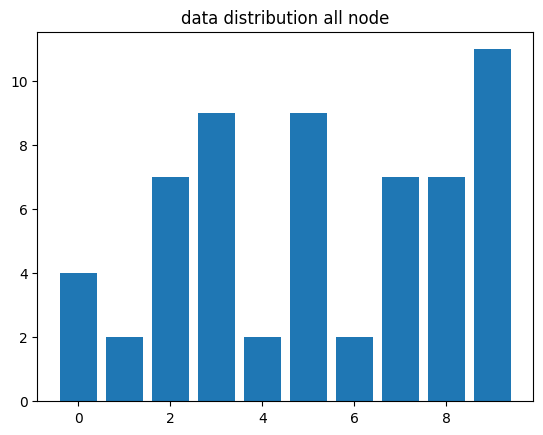

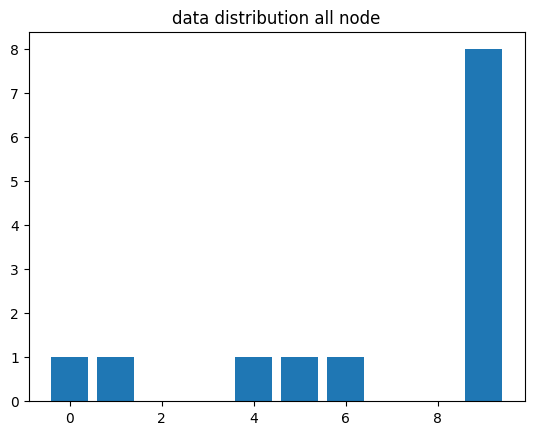

In [42]:
training_list_dataset = simulate_data(train_dataset, args.K)
valid_list_dataset = simulate_data(valid_dataloader, args.K)

In [43]:
training_sets = [DataLoader(dataset=data, batch_size=args.B, shuffle=True) for data in training_list_dataset]

In [44]:
#valid_sets = [DataLoader(dataset=data, batch_size=args.B, shuffle=True) for data in valid_list_dataset]

## 4.2 Các hàm chính của FD

In [45]:
# sử dụng các trọng số đã được đạo tạo trước
model = vit_b_16(weights = weights)

In [46]:
# đóng băng các tham số
for param in model.conv_proj.parameters():
    param.requires_grad = False

In [47]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [48]:
output_shape = len(classes)

model.heads = nn.Sequential(OrderedDict([('head', nn.Linear(in_features = 768, 
                                                            out_features = output_shape))]))

In [49]:
# chú thích tính sự khác nhau giữa 2 model
def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    
    tensor_1=list(model_1.parameters())
    tensor_2=list(model_2.parameters())
    
    norm=sum([torch.sum((tensor_1[i]-tensor_2[i])**2) for i in range(len(tensor_1))])
    
    return norm

In [50]:
def loss_dataset(model, dataset, loss_fn):
    """Compute the loss of `model` on `dataset`"""
    train_loss=0
    
    for batch,(X,y) in enumerate(dataset):
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        y_pred_logit = model(X)
        
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()
    
    train_loss = train_loss/len(dataset)
    return train_loss

In [51]:
def train_step_FD_Prox(model, model_0,mu:int,optimizer, dataloader,loss_fn):
    
    model.train()
    
    train_loss = 0.
    train_accuracy = 0.
    
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        y_pred_logit = model(X)
        
        loss = loss_fn(y_pred_logit, y)
        
        #thêm
        loss+=mu/2*difference_models_norm_2(model,model_0)
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    '''y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        train_accuracy += accuracy_score(y.cpu().numpy(), 
                                         y_pred_class.detach().cpu().numpy())'''
        
    train_loss = train_loss/len(dataloader)
    #train_accuracy = train_accuracy/len(dataloader)
    
    return train_loss

In [52]:
def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):
    
    model_0=deepcopy(model)
    
    for e in range(epochs):
        local_loss=train_step_FD_Prox(model,model_0,mu,optimizer,train_data,loss_f)
        
    return local_loss

In [53]:
def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)

In [54]:
def average_models(model, clients_models_hist:list , weights:list):


    """Creates the new model of a given iteration with the models of the other
    clients"""
    
    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):
        
        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)
            
    return new_model

In [55]:
def train_FD_Prox(model, training_sets, epochs, mu,device,n_iter,lr,decay):
    #Variables initialization
    loss_fn = nn.CrossEntropyLoss() 
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    
    train_loss = [[float(loss_dataset(model, dl, loss_fn)) for dl in training_sets]]
    #######################################################################################
       
    
    
    server_loss=sum([weights[i]*train_loss[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss}')
    
    
    #########################################################################################
    for i in range(n_iter):
        
        clients_params=[] # tham số từng node
        clients_models=[] # model đc cập nhật ở từng node
        clients_losses=[] # loss từng node
        
        for k in range(K):
            
            local_model=deepcopy(model)
            local_optimizer=optim.Adam(local_model.parameters(),lr=lr)
            
            local_loss=local_learning(local_model,mu,local_optimizer, training_sets[k],epochs,loss_fn)
            clients_losses.append(local_loss)
                
            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)    
            clients_models.append(deepcopy(local_model))
        # tạo ra mô hình toàn cầu mới
        
        model = average_models(deepcopy(model), clients_params, weights=weights)
        #models_hist.append(clients_models)
        
        # TÍNH TOÁN MẤT/ĐỘ CHÍNH XÁC CỦA CÁC KHÁCH HÀNG KHÁC NHAU BẰNG MÔ HÌNH MỚI
        train_loss+=[[float(loss_dataset(model, dl, loss_fn)) for dl in training_sets]]
        server_loss=sum([weights[i]*train_loss[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss}')
        lr*=decay
    
    
    return model,train_loss

In [56]:
EPOCHS = 20

#torch.cuda.manual_seed(SEED)
#torch.manual_seed(SEED)

MODEL_RESULTS_FD , loss = train_FD_Prox(model.to(device), training_sets, EPOCHS,mu=args.mu,device=args.device,n_iter=args.n_iter,lr=args.lr, decay=1)

====> i: 0 Loss: 1.1204938878615696
====> i: 1 Loss: 1.0971213638782502
====> i: 2 Loss: 1.0746457636356355
====> i: 3 Loss: 1.0529666046301522
====> i: 4 Loss: 1.031753173470497
====> i: 5 Loss: 1.0110989431540172
====> i: 6 Loss: 0.9911640316247939
====> i: 7 Loss: 0.9716873129208883
====> i: 8 Loss: 0.9526658674081165
====> i: 9 Loss: 0.9341569940249124
====> i: 10 Loss: 0.9161609927813212
====> i: 11 Loss: 0.8985429992278418
====> i: 12 Loss: 0.8812635198235511
====> i: 13 Loss: 0.8644819145401319
====> i: 14 Loss: 0.8480587184429168
====> i: 15 Loss: 0.8320353840788206
====> i: 16 Loss: 0.8163364281256993
====> i: 17 Loss: 0.8009165381391843
====> i: 18 Loss: 0.7858241101106007
====> i: 19 Loss: 0.7711144258578617
====> i: 20 Loss: 0.7567651465535162
====> i: 21 Loss: 0.7427631691098213
====> i: 22 Loss: 0.7290046130617459
====> i: 23 Loss: 0.7155914897720018
====> i: 24 Loss: 0.702478425204754
====> i: 25 Loss: 0.6896561160683631
====> i: 26 Loss: 0.6770436987280846
====> i: 27 L

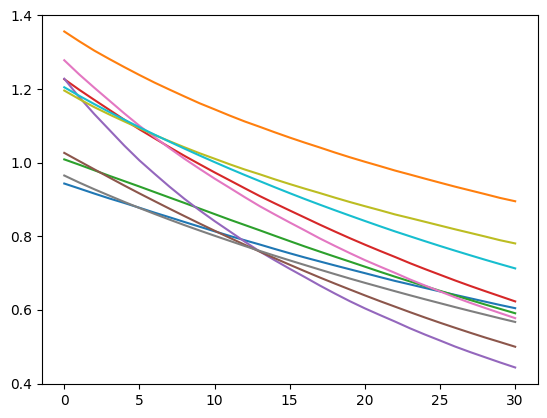

In [57]:
plt.plot(loss)

## 4.3 Dự đoán đánh giá bằng model học liên kết

In [58]:
torch.save(MODEL_RESULTS_FD.state_dict(), '/kaggle/working/my_model_FDProx.pth')

In [59]:
# We define the model again with its respective modification.
loaded_model = vit_b_16()

loaded_model.heads = nn.Sequential(OrderedDict([('head',nn.Linear(in_features = 768, 
                                                                  out_features = output_shape))]))

loaded_model.load_state_dict(torch.load('/kaggle/working/my_model_FDProx.pth'))

# We now infer
loaded_model.to(device)

loaded_model.eval()

y_pred_test = []

with torch.inference_mode():
    for X,y in tqdm(test_dataloader):
        X,y = X.to(device), y.to(device)
        y_pred_logit = loaded_model(X)
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        y_pred_test.append(y_pred_class.detach().cpu())

  0%|          | 0/14 [00:00<?, ?it/s]

In [60]:
y_pred_test = torch.cat(y_pred_test).numpy()

In [61]:
print(f'Accuracy = {round(accuracy_score(df_test["label"].map(label_map), y_pred_test), 4)}')

Accuracy = 0.6429


In [62]:
confusion_matrix_test = confusion_matrix(df_test["label"].map(label_map), y_pred_test)

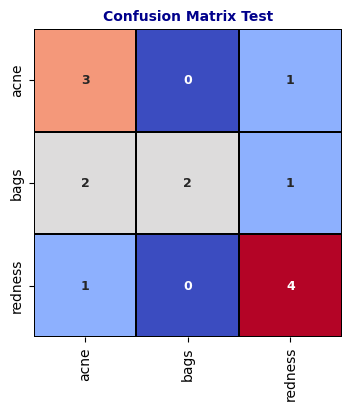

In [63]:
fig,ax = plt.subplots(figsize = (15,4))
sns.heatmap(confusion_matrix_test, 
            cmap = 'coolwarm', 
            annot = True, 
            annot_kws = {"fontsize":9, "fontweight":"bold"}, 
            linewidths = 1.2, 
            linecolor = "black", 
            square = True, 
            xticklabels = classes, 
            yticklabels = classes, 
            cbar = False,
            ax = ax)
ax.set_title("Confusion Matrix Test", fontsize = 10, fontweight = "bold", color = "darkblue")
ax.tick_params('x',rotation = 90)
fig.show()